# River GPT Illustration Project

*How much data analysis and data visualization can be coded by GPT LLMs through conversational interface with me on the other side?*

This is the animating question for what is to follow. On one side I have this Jupyter Notebook in which I will execute a run of the mill data analysis of run of the mill, real-world open data. On the other side I have ChatGPT and Bing AI Chat that I prompt with requests and questions in plain English. How much of the data analysis code generated by these two LLMs is functional and useful to the data analysis task? 

My exploration aims especially at the iterated exchange between what I learn and encounter as the two sides, the notebook and the LLMs, interact with me in between as the referee, facilitator, mediator, interpreter, problem owner, human in the loop (take your pick). To disprove the idea that a single prompt is enough to generate good and functional code is not worthwhile.

Why River GPT? Is it metaphorical perhaps for the flow of our back-and-forth conversations? If you like, sure, but it relates to the data as well: multiple time-series of water flow in the Rhein river and its upstream rivers.

In [147]:
!pip install scipy pandas seaborn matplotlib

## The Data and Its Parsing
**I prompt Bing AI** with the question: *So, I am curious about hydrology and especially historical data on the water flow in European rivers. I wish to download some data for analysis on that. What sites or databases do you suggest?*

Three sites are suggested and after some quick checks, I find the Global Runoff Data Centre (GRDC) the most interesting: https://portal.grdc.bafg.de/applications/public.html?publicuser=PublicUser#dataDownload/Subregions

I proceed to download all data related to the Rhein river basin.

Now, this was done by registering with some nice, sleek Web API with well crated documentation and clever querying abilities which then returns nice and clean data in JSON or CSV. It involved sending an email request and obtaining a ZIP file of several ASCII files.

A typical ASCII file looks like this:

Easy to understand for the human reader. But I want to parse it and put the data into Pandas DataFrames to get the analysis going. Also, I note that there is relevant metadata dispersed in the leading comment field.

**I prompt ChatGPT**: *Hi there. I have some data files on the flux in the river Rhein and rivers in its basin. I need help parsing them and extracting the relevant data and metadata. I work in Python and preferably with the Pandas library. So first I want to give you a flavour of the file content and then lets talk about the data I want help extracting. Sound good?*

In customary politeness ChatGPT is ready, and I then paste in the snippet of ASCII file shown above. To this ChatGPT provides a code snippet:

In [219]:
import os
import pandas as pd

metadata_labels = {
    '# River:': 'river',
    '# Station:': 'station',
    '# Latitude (DD):': 'latitude',
    '# Longitude (DD):': 'longitude',
    '# Catchment area (km≤):': 'catchment_area',
    '# Altitude (m ASL):': 'altitude',
    '# Next downstream station:': 'next_downstream_station',
    '# Remarks:': 'remarks',
    '# Owner of original data:': 'owner_of_original_data',
    '# GRDC-No.:': 'grdc_number',
    '# Unit of measure:': 'unit_of_measure',
}

metadata_df = pd.DataFrame(columns=list(metadata_labels.values()))
flux_data_df = pd.DataFrame()

folder_path = 'data'

# Loop over files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    metadata = {}
    data_start_row = None
    data = None

    with open(file_path, encoding='latin-1') as file:
        lines = file.readlines()

        # Parse metadata and find start row of the data
        for i, line in enumerate(lines):
            if line.startswith('# Data lines:'):
                data_start_row = i + 2  # Skip two lines after the metadata line
                break

            for key, value in metadata_labels.items():
                if line.startswith(key):
                    metadata[value] = line.split(':')[1].strip()

        # Read the data from the file
        if data_start_row:
            data = pd.read_csv(file_path, delimiter=';', skiprows=data_start_row, encoding='latin-1')
            data.columns = data.columns.str.strip()
            data['GRDC-No.'] = metadata['grdc_number']
            flux_data_df = pd.concat([flux_data_df, data])

    if 'grdc_number' in metadata:
        grdc_number = metadata['grdc_number']
        metadata_df.loc[grdc_number] = metadata

# Set the index of the flux data DataFrame
flux_data_df.set_index(['GRDC-No.', 'YYYY-MM-DD'], inplace=True)

In [220]:
import numpy as np

flux_data_df['Value'] = flux_data_df['Value'].replace(-999.0, np.nan)
flux_data_df = flux_data_df.dropna()

In [221]:
# Convert the 'YYYY-MM-DD' string to datetime
flux_data_df['Date'] = pd.to_datetime(flux_data_df.index.get_level_values(1))

# Extract the levels into separate columns
flux_data_df['GRDC-No.'] = flux_data_df.index.get_level_values(0)
flux_data_df['Year'] = flux_data_df['Date'].dt.year
flux_data_df['Month'] = flux_data_df['Date'].dt.month_name()
flux_data_df['Day'] = flux_data_df['Date'].dt.day

# Rename the index levels if desired
flux_data_df.index.names = ['GRDC-No.', 'Date']

In [222]:
flux_data_df.drop(['Date','GRDC-No.'],axis=1, inplace=True)
flux_data_df.head()

hh:mm  Value  Year     Month  Day
GRDC-No. Date                                         
6335620  1980-11-01  --:--  0.637  1980  November    1
         1980-11-02  --:--  0.571  1980  November    2
         1980-11-03  --:--  0.466  1980  November    3
         1980-11-04  --:--  0.385  1980  November    4
         1980-11-05  --:--  0.402  1980  November    5

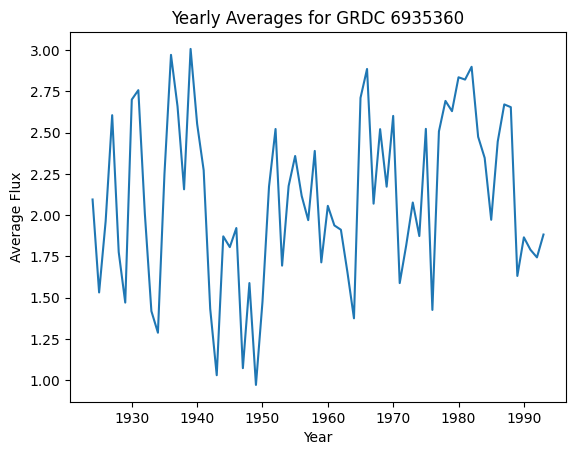

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Convert 'Date' index to datetime format
flux_data_df.index = [flux_data_df.index.get_level_values('GRDC-No.'), pd.to_datetime(flux_data_df.index.get_level_values('Date'))]

# Compute yearly averages for each GRDC-No.
yearly_averages = flux_data_df.groupby([flux_data_df.index.get_level_values('GRDC-No.'), flux_data_df.index.get_level_values('Date').year])['Value'].mean()

# Reset the index to make GRDC-No. and Year as columns
yearly_averages = yearly_averages.reset_index()

# Set the desired GRDC number
grdc_number = '6935360'

# Filter the yearly averages for the specified GRDC number
grdc_yearly_averages = yearly_averages[yearly_averages['GRDC-No.'] == grdc_number]

# Plot the yearly averages for the specified GRDC number using Seaborn
sns.lineplot(x='Date', y='Value', data=grdc_yearly_averages)

# Set the plot title and labels
plt.title(f'Yearly Averages for GRDC {grdc_number}')
plt.xlabel('Year')
plt.ylabel('Average Flux')

# Display the plot
plt.show()


In [224]:
import pandas as pd
from scipy.stats import linregress

# Assuming you have already created the `flux_data_df` dataframe

# Calculate the minimum year for each GRDC
min_year_per_grdc = flux_data_df.groupby('GRDC-No.')['Year'].min()

# Normalize the year values by subtracting the minimum year for each GRDC
flux_data_df['Normalized Year'] = flux_data_df.groupby('GRDC-No.').apply(lambda x: x['Year'] - min_year_per_grdc[x.name]).values

# Calculate the average annual flux for each GRDC and normalized year
avg_flux_per_year = flux_data_df.groupby(['GRDC-No.', 'Normalized Year'])['Value'].mean().reset_index()

# Perform linear regression analysis on the normalized year values
linear_regression_df = avg_flux_per_year.groupby('GRDC-No.').apply(lambda x: linregress(x['Normalized Year'], x['Value']))

# Create a new dataframe for the linear regression results
linear_regression_results = pd.DataFrame(linear_regression_df.tolist(), columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])
linear_regression_results.index = linear_regression_df.index

# Add the R-squared column to the linear_regression_results dataframe
linear_regression_results['R-squared'] = linear_regression_results['rvalue']**2


In [225]:
print(linear_regression_results.nsmallest(5, 'slope'))
print(linear_regression_results.nlargest(5, 'intercept'))
print(linear_regression_results.describe())
print(linear_regression_results.loc['6935318']['intercept'])

             slope    intercept    rvalue    pvalue    stderr  R-squared
GRDC-No.                                                                
6335150  -6.618037  2000.689485 -0.264873  0.108034  4.015554   0.070158
6935051  -1.483461  1093.457852 -0.228461  0.067180  0.796440   0.052195
6335070  -1.335975  2086.807318 -0.076982  0.473346  1.855063   0.005926
6435060  -0.864573  2263.743693 -0.063221  0.503977  1.289619   0.003997
6335100  -0.601291  1686.611363 -0.033658  0.807271  2.452543   0.001133
             slope    intercept    rvalue    pvalue    stderr  R-squared
GRDC-No.                                                                
6435060  -0.864573  2263.743693 -0.063221  0.503977  1.289619   0.003997
6335020   0.805507  2225.009262  0.064771  0.524156  1.260047   0.004195
6335070  -1.335975  2086.807318 -0.076982  0.473346  1.855063   0.005926
6335050   1.377078  2064.332414  0.079903  0.530247  2.181775   0.006384
6335060   1.816243  2045.389426  0.127662  0.387203

In [226]:
metadata_df.loc['6935340']

river                                                          SPERBELGRABEN
station                                                                WASEN
latitude                                                             47.0158
longitude                                                             7.8427
catchment_area                                                           NaN
altitude                                                               960.1
next_downstream_station                                              6935302
remarks                                                                     
owner_of_original_data     Switzerland - Federal Office for the Environme...
grdc_number                                                          6935340
unit_of_measure                                                         m³/s
Name: 6935340, dtype: object

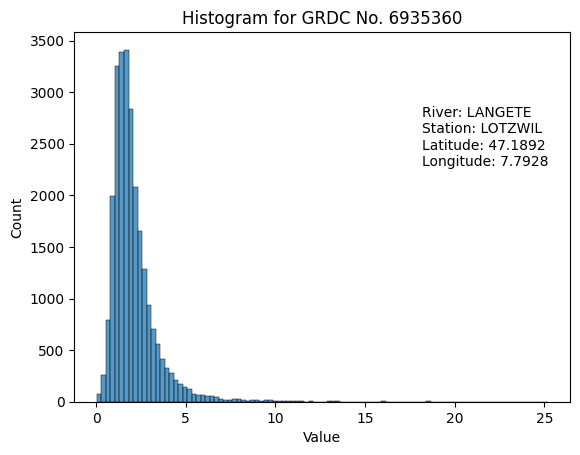

In [275]:
grdc_number = '6935360'
sns.histplot(data=flux_data_df.loc[grdc_number], x='Value', bins=100)
# Set plot title
plt.title(f"Histogram for GRDC No. {grdc_number}")

# Add metadata to the upper-right part of the plot
metadata = metadata_df.loc[grdc_number]
metadata_text = f"River: {metadata['river']}\nStation: {metadata['station']}\nLatitude: {metadata['latitude']}\nLongitude: {metadata['longitude']}"
plt.text(0.7, 0.8, metadata_text, transform=plt.gca().transAxes, fontsize=10, va='top')

# Display the plot
plt.show()

0.08234721801506796


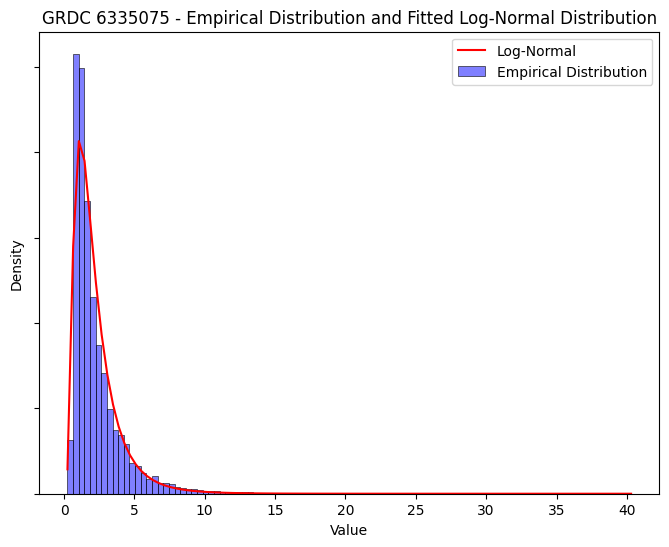

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, gamma, weibull_min
import scipy.integrate as integrate

# Assuming you have the GRDC number and distribution type
grdc_number = '6335075'
distribution_type = 'lognorm'
num_bins = 100

# Get the data for the specific GRDC number
grdc_data = flux_data_df.loc[grdc_number, 'Value'].dropna()
grdc_data = grdc_data.replace(0.0, 0.01)

# Integrate the histogram
hist, bin_edges = np.histogram(grdc_data, bins=num_bins)
bin_widths = np.diff(bin_edges)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
integral = np.trapz(hist, x=bin_midpoints)

# Fit the chosen distribution to the data
if distribution_type == 'lognorm':
    params = lognorm.fit(grdc_data, floc=0)
    fitted_distribution = lognorm(*params)
    distribution_label = 'Log-Normal'
elif distribution_type == 'gamma':
    params = gamma.fit(grdc_data)
    fitted_distribution = gamma(*params)
    distribution_label = 'Gamma'
elif distribution_type == 'weibull':
    params = weibull_min.fit(grdc_data)
    fitted_distribution = weibull_min(*params)
    distribution_label = 'Weibull'

# Plot the histogram of the empirical data and the fitted distribution
plt.figure(figsize=(8, 6))
plot = sns.histplot(grdc_data, kde=False, stat='density', color='blue', alpha=0.5, bins=num_bins, label='Empirical Distribution')
plot.set_yticklabels([])
x = np.linspace(grdc_data.min(), grdc_data.max(), 100)
plt.plot(x, fitted_distribution.pdf(x), color='red', label=distribution_label)
plt.xlabel('Value')
#plt.ylabel('Normalized Frequency')
plt.title(f'GRDC {grdc_number} - Empirical Distribution and Fitted {distribution_label} Distribution')

tot = 0.0
for a, b in zip(hist, fitted_distribution.pdf(x)):
    tot += (a / integral - b) ** 2
print (tot)

plt.legend()
plt.show()


In [233]:
import numpy as np
from scipy.stats import lognorm, gamma, weibull_min
import scipy.integrate as integrate

num_bins = 100
fit_df = pd.DataFrame(columns=['GRDC-No.','lognormal','gamma','weibull'])

fit_data = []
for grdc_number in flux_data_df.index.get_level_values('GRDC-No.').unique():

    # Get the data for the specific GRDC number
    grdc_data = flux_data_df.loc[grdc_number, 'Value'].dropna()
    grdc_data = grdc_data.replace(0.0, 0.01)
    
    # Skip if intercept lower than threshold
    if linear_regression_results.loc[grdc_number]['intercept'] < 2.0:
        continue

    # Integrate the histogram
    hist, bin_edges = np.histogram(grdc_data, bins=num_bins)
    bin_widths = np.diff(bin_edges)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    integral = np.trapz(hist, x=bin_midpoints)

    # Fit the chosen distribution to the data
    params = lognorm.fit(grdc_data, floc=0)
    fitted_distribution_lognorm = lognorm(*params)
    
    params = gamma.fit(grdc_data)
    fitted_distribution_gamma = gamma(*params)

    params = weibull_min.fit(grdc_data)
    fitted_distribution_weibull = weibull_min(*params)

    # Make fitted data sample
    x = np.linspace(grdc_data.min(), grdc_data.max(), 100)

    tot_lognorm = 0.0
    for a, b in zip(hist, fitted_distribution_lognorm.pdf(x)):
        tot_lognorm += (a / integral - b) ** 2
    tot_gamma = 0.0
    for a, b in zip(hist, fitted_distribution_gamma.pdf(x)):
        tot_gamma += (a / integral - b) ** 2
    tot_weibull = 0.0
    for a, b in zip(hist, fitted_distribution_weibull.pdf(x)):
        tot_weibull += (a / integral - b) ** 2
        
    fit_df.loc[len(fit_df)] = [grdc_number, tot_lognorm, tot_gamma, tot_weibull]

print (fit_df)

    GRDC-No.     lognormal         gamma       weibull
0    6335060  3.912480e-08  5.385055e-07  2.455973e-07
1    6335800  1.858757e-04  2.834447e-04  3.724737e+00
2    6935530  2.543454e-02  2.719183e+02  1.645886e+01
3    6935052  3.558414e-07  1.981947e-07  1.334638e-07
4    6335351  2.222651e-03  5.875792e+23  2.196164e+00
..       ...           ...           ...           ...
143  6335320  2.291000e-02  4.294095e-02  3.526379e-02
144  6335651  6.154583e-02  7.484262e+25  6.709685e-02
145  6935402  1.238207e-03  6.620967e-04  6.658888e+02
146  6935545  1.315054e-01  6.568197e-02  4.194638e+02
147  6335082  2.439567e-03  4.566239e+21  1.957313e-03

[148 rows x 4 columns]


In [253]:
fit_df.nlargest(15, 'lognormal')

,GRDC-No.,lognormal,gamma,weibull
45,6935570,6.222765,2.481432e+27,1.899749e+27
92,6235110,0.335721,1.212432e+21,1.488815e+04
5,6135210,0.267018,1.494441e+27,8.268733e+08
6,6235200,0.225549,1.715929e+28,1.065533e+13
107,6335676,0.168146,3.948580e+28,3.907688e+13
123,6935100,0.136446,1.499428e+21,6.353017e+02
72,6935510,0.132349,4.891206e+22,1.367556e+06
146,6935545,0.131505,6.568197e-02,4.194638e+02
69,6235102,0.120701,1.265929e+05,2.124018e+03
80,6335671,0.108291,1.995862e+13,7.225294e-02


In [237]:
import pandas as pd
import numpy as np

def calculate_correlation_matrix(flux_data_df):
    unique_grdc_values = flux_data_df.index.get_level_values('GRDC-No.').unique()
    correlation_data = []

    # Iterate over unique pairs of GRDC values
    for i in range(len(unique_grdc_values)):
        grdc_no1 = unique_grdc_values[i]
        
        for j in range(i + 1, len(unique_grdc_values)):
            grdc_no2 = unique_grdc_values[j]
            
            # Get the rows for the two GRDC-No.
            df1 = flux_data_df.loc[grdc_no1]
            df2 = flux_data_df.loc[grdc_no2]
            
            # Merge the two DataFrames on the Date index.
            merged_df = pd.merge(df1, df2, on='Date', suffixes=['_' + grdc_no1, '_' + grdc_no2])
            
            # Calculate the Pearson correlation between the "Value" columns.
            correlation = merged_df['Value_' + grdc_no1].corr(merged_df['Value_' + grdc_no2])
            
            # Append correlation data to the list
            correlation_data.append([grdc_no1, grdc_no2, correlation])
    
    # Create a new DataFrame with the correlation data
    correlation_df = pd.DataFrame(correlation_data, columns=['GRDC-No. 1', 'GRDC-No. 2', 'Correlation'])
    
    # Set the index on the two GRDC values
    correlation_df.set_index(['GRDC-No. 1', 'GRDC-No. 2'], inplace=True)
    
    return correlation_df


In [240]:
df_corr_mat = calculate_correlation_matrix(flux_data_df)
print (df_corr_mat)

                       Correlation
GRDC-No. 1 GRDC-No. 2             
6335620    6335060        0.559658
           6335800        0.635145
           6935460        0.506148
           6935530       -0.224654
           6935102        0.197103
...                            ...
6335651    6935545        0.156599
           6335082        0.345578
6935402    6935545        0.440077
           6335082        0.228914
6935545    6335082       -0.080789

[18915 rows x 1 columns]


In [245]:
df_corr_mat.nsmallest(5, 'Correlation')

,,Correlation
GRDC-No. 1,GRDC-No. 2,
6135200,6935385,-0.345920
6335620,6935385,-0.335418
6935570,6335048,-0.326166
6335240,6935385,-0.318569
6335302,6935385,-0.315407


In [241]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_scatterplot(flux_data_df, grdc_no1, grdc_no2):
    # Get the rows for the two GRDC-No.
    df1 = flux_data_df.loc[grdc_no1]
    df2 = flux_data_df.loc[grdc_no2]
    
    # Merge the two DataFrames on the Date index.
    merged_df = pd.merge(df1, df2, on='Date', suffixes=['_' + grdc_no1, '_' + grdc_no2])
    
    # Create scatterplot using Seaborn
    sns.scatterplot(data=merged_df, x='Value_' + grdc_no1, y='Value_' + grdc_no2)
    plt.xlabel(grdc_no1)
    plt.ylabel(grdc_no2)
    plt.title(f"Scatterplot: {grdc_no1} vs {grdc_no2}")
    plt.show()


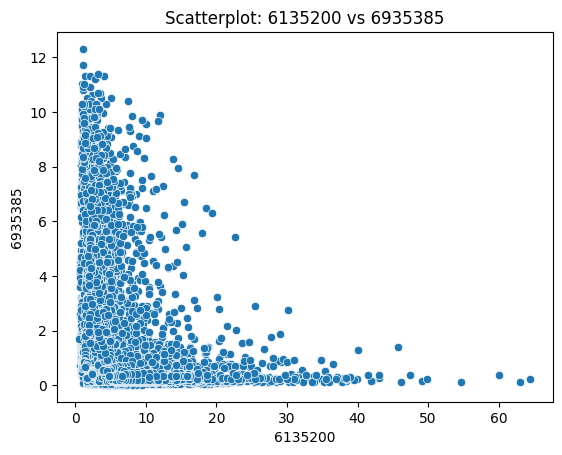

In [246]:
create_scatterplot(flux_data_df, '6135200', '6935385')

In [256]:
flux_data_df['Z-score'] = flux_data_df.groupby('GRDC-No.')['Value'].transform(lambda x: (x - x.mean()) / x.std())
    
# Calculate maximum normalization for each GRDC-No.
flux_data_df['Max-normalized'] = flux_data_df.groupby('GRDC-No.')['Value'].transform(lambda x: x / x.max())


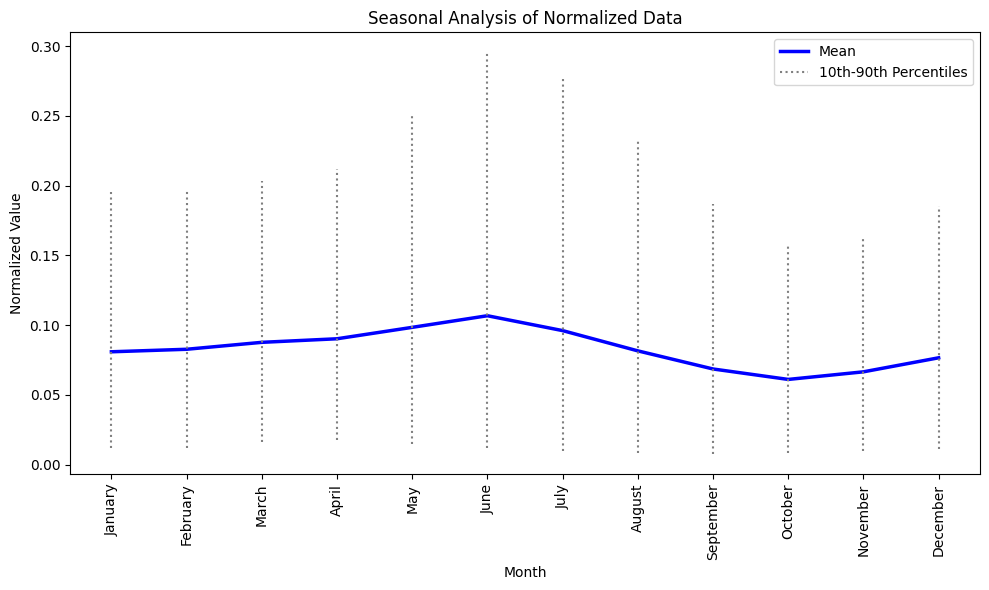

               Mean  Variance  10th Percentile  90th Percentile
Month                                                          
January    0.080868  0.008894         0.011710         0.195288
February   0.082667  0.008802         0.012174         0.197351
March      0.087638  0.008194         0.015933         0.203284
April      0.090194  0.007729         0.017788         0.211616
May        0.098376  0.011386         0.014625         0.251376
June       0.106701  0.015941         0.012013         0.295413
July       0.096040  0.014637         0.009504         0.276327
August     0.081526  0.011085         0.008055         0.233213
September  0.068543  0.007418         0.007687         0.187037
October    0.061057  0.005547         0.008031         0.157821
November   0.066505  0.006393         0.009704         0.163325
December   0.076559  0.008042         0.011381         0.185366


In [264]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_seasonal_data(flux_data_df):
    # Define custom order for sorting months
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

    # Aggregate the data based on the Month column
    aggregated_data = flux_data_df.groupby('Month')['Max-normalized'].agg(['mean', 'var', lambda x: x.quantile(0.1), lambda x: x.quantile(0.9)]).reindex(month_order)

    # Rename columns for plotting
    aggregated_data.columns = ['Mean', 'Variance', '10th Percentile', '90th Percentile']

    # Plot the aggregated data
    plt.figure(figsize=(10, 6))

    # Plot mean as a thicker blue line
    sns.lineplot(data=aggregated_data['Mean'], color='blue', linewidth=2.5, label='Mean')

    # Plot vertical lines for 10th and 90th percentiles
    plt.vlines(aggregated_data.index, aggregated_data['10th Percentile'], aggregated_data['90th Percentile'], colors='gray', linestyles='dotted', label='10th-90th Percentiles')

    # Customize the plot
    plt.xlabel('Month')
    plt.ylabel('Normalized Value')
    plt.title('Seasonal Analysis of Normalized Data')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees counterclockwise
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

    return aggregated_data



# Analyze and plot the seasonal data
seasonal_data = analyze_seasonal_data(flux_data_df)

# Print the aggregated data
print(seasonal_data)

In [270]:
import numpy as np
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


# Calculate the mean squared difference for each GRDC
mean_squared_diff = {}
for grdc, grdc_data in flux_data_df.groupby(level='GRDC-No.'):
    grdc_seasonal_data = grdc_data.groupby('Month')['Max-normalized'].mean().reindex(month_order)
    squared_diff = np.square(grdc_seasonal_data - seasonal_data['Mean'])
    mean_squared_diff[grdc] = np.mean(squared_diff)

# Find the GRDC with the lowest mean squared difference
most_similar_grdc = min(mean_squared_diff, key=mean_squared_diff.get)

print(f"The GRDC with the seasonal variation most similar to the total system is GRDC-No. {most_similar_grdc}")

# Create a DataFrame from the mean_squared_diff dictionary
df_mean_squared_diff = pd.DataFrame(mean_squared_diff.items(), columns=['GRDC-No.', 'Mean Squared Difference'])

# Set GRDC-No. as the index
df_mean_squared_diff.set_index('GRDC-No.', inplace=True)

# Print the DataFrame
print(df_mean_squared_diff.nsmallest(10, 'Mean Squared Difference'))


The GRDC with the seasonal variation most similar to the total system is GRDC-No. 6935360
          Mean Squared Difference
GRDC-No.                         
6935360                  0.000173
6935361                  0.000227
6335461                  0.000228
6935080                  0.000246
6335460                  0.000254
6335610                  0.000277
6335550                  0.000285
6335175                  0.000404
6335470                  0.000414
6935060                  0.000467


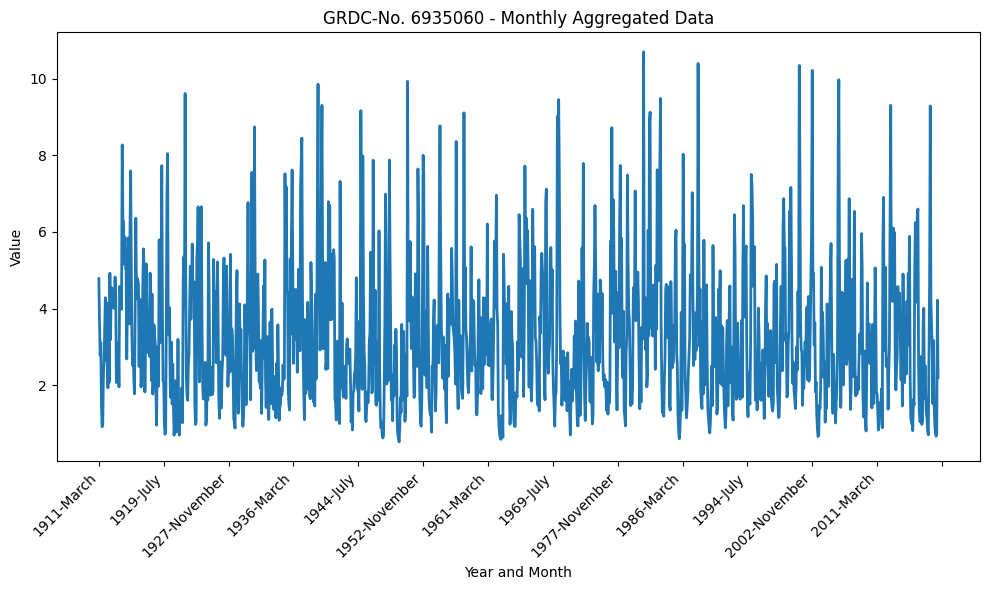

In [299]:
import matplotlib.pyplot as plt

def plot_grdc_data(grdc_number):
    # Filter data for the specific GRDC number
    grdc_data = flux_data_df.loc[grdc_number]

    # Group and aggregate by Year and Month while preserving the columns
    aggregated_data = grdc_data.groupby(['Year', 'Month']).agg({'Value': 'mean'})

    # Sort the aggregated data by Year and Month
    aggregated_data = aggregated_data.reindex(month_order, level='Month')

    # Generate x-axis labels
    x_labels = [f"{year}-{month}" for year, month in aggregated_data.index]

    # Plot the GRDC data
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, aggregated_data['Value'], linewidth=2)
    plt.xlabel('Year and Month')
    plt.ylabel('Value')
    plt.title(f'GRDC-No. {grdc_number} - Monthly Aggregated Data')
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(15))
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

# Specify the GRDC number for the plot
grdc_number = '6935060'

# Plot the data for the specific GRDC number
plot_grdc_data(grdc_number)



In [213]:
def describe_df_as_prompt(df, object_name):
    prompt = 'A Pandas DataFrame instance, named {}. '.format(object_name)
    prompt += 'It has {} number of rows and {} number of columns. '.format(df.shape[0], df.shape[1])
    prompt += 'The DataFrame is indexed with a {}. '.format(df.index.__class__.__name__)
    if len(df.index.names) > 1:
        prompt += 'There are {} number of indices and their names are: '.format(len(df.index.names))
        for name in df.index.names[:-1]:
            prompt += '{}, '.format(name)
        prompt += 'and {}. '.format(df.index.names[-1])
    prompt += 'The column names are: '
    for col in df.columns[:-1]:
        prompt += '{}, '.format(col)
    prompt += 'and {}. '.format(df.columns[-1])
    
    return prompt

In [266]:
describe_df_as_prompt(flux_data_df, 'flux_data_df')

'A Pandas DataFrame instance, named flux_data_df. It has 5266038 number of rows and 8 number of columns. The DataFrame is indexed with a MultiIndex. There are 2 number of indices and their names are: GRDC-No., and Date. The column names are: hh:mm, Value, Year, Month, Day, Normalized Year, Z-score, and Max-normalized. '

In [216]:
import pandas as pd
import numpy as np

# Define column names
columns = ['hh:mm', 'Value', 'Year', 'Month', 'Day', 'Normalized Year']

# Define index values
grdc_values = ['GRDC-1']
date_values = ['2023-06-08']

# Create MultiIndex
index = pd.MultiIndex.from_arrays([grdc_values, date_values], names=['GRDC-No.', 'Date'])

# Create random data for the row
random_data = [np.random.randint(0, 10) for _ in range(len(columns))]

# Create DataFrame with one row of data
flux_data_df = pd.DataFrame([random_data], columns=columns, index=index)

# Print the DataFrame
print(flux_data_df)


                     hh:mm  Value  Year  Month  Day  Normalized Year
GRDC-No. Date                                                       
GRDC-1   2023-06-08      4      2     0      8    3                5
